In [1]:
import clrs
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pprint
from scipy.optimize import linear_sum_assignment

rng = np.random.RandomState(1234)
rng_key = jax.random.PRNGKey(rng.randint(2 ** 32))

%load_ext autoreload
%autoreload 2

2023-05-25 00:08:50.257262: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/anders/miniconda3/envs/clrs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
#  "# =================== BIPARTITE GRAPH GENERATOR SPECS =========================\n",
#   "# - Erdos Reyni (ER)\n",
#   "#     Generates an Erdos-Reyni random graph with edge probability [p]. If\n",
#   "#       [weighted], edge weights are iid uniform([low], [high])\n",
#   "#\n",
#   "#     {'generator': ER, 'weighted': False, 'p': 0.5, 'low': 0.0, 'high': 1.0}\n",
#   "#\n",
#   "# - Barabasi-Albert (BA)\n",
#   "#     Generates a Barabasi-Albert random graph with parameter [ba_param]. If\n",
#   "#       [weighted], edge weights are iid uniform([low], [high])\n",
#   "#\n",
#   "#     {'generator': BA, 'ba_param': 1, 'weighted': False, 'low': 0.0, 'high': 1.0}\n",
#   "#\n",
#   "# - Geometric (GEOMETRIC)\n",
#   "#     Generates a random graph by embedding nodes uniformly over the unit\n",
#   "#       square. Edge weights are the euclidean distance between two nodes,\n",
#   "#       with weights below [threshold] set to 0, then scaled by [scaling].\n",
#   "#\n",
#   "#     {'generator': GEOMETRIC, 'threshold': 0.25, 'scaling': 1.0}\n",
#   "#\n",
#   "# - Flow (FLOW)\n",
#   "#     Generates a random ER reduction to a max flow input, with edge\n",
#   "#       probability [p].\n",
#   "#     {'generator': FLOW, 'p': 0.5}\n",
#   "\n",
#   "\n",
#   "\n",

In [3]:
# If you don't want BipartiteMatching, just pass empty generator list and
# length separately

sampler_spec = {
    'num_samples': 100,
    'batch_size': 32,
    'schematics': [
        {
            'generator': 'ER',
            'proportion': 0.5,
            'length': 16,
            'kwargs': {'p': 1, 'low': 5, 'high': 100, 'weighted': True}
        },
        {
            'generator': 'ER',
            'proportion': 0.5,
            'length': 16,
            'kwargs': {'p': 1, 'low': 1, 'high': 1.0001, 'weighted': True}
        },
    ]
}

def samplers(sampler_spec, batch_size, **kwargs):

    def _iterate_sampler(sampler, batch_size):
        while True:
            yield sampler.next(batch_size)

    sampler, spec = clrs.build_sampler(
        name = 'simplified_min_sum',
        sampler_spec = sampler_spec,
        **kwargs)  # number of nodes

    sampler = _iterate_sampler(sampler, batch_size = batch_size)
    return sampler, spec

train_sampler, spec = samplers(sampler_spec, 1)

In [4]:
def define_model(spec, train_sampler, model = "mpnn"):
    if model == "mpnn":
        processor_factory = clrs.get_processor_factory('mpnn', use_ln = True,
                                                   nb_triplet_fts = 0)  #use_ln => use layer norm
    elif model == "gat":
        processor_factory = clrs.get_processor_factory('gat', use_ln=True, nb_heads = 4, nb_triplet_fts = 0)

    model_params = dict(
        processor_factory = processor_factory,  # contains the processor_factory
        hidden_dim = 32,  # TODO put back to 32 if no difference
        encode_hints = True,
        decode_hints = True,
        #decode_diffs=False,
        #hint_teacher_forcing_noise=1.0,
        hint_teacher_forcing = 1.0,
        use_lstm = False,
        learning_rate = 0.001,
        checkpoint_path = '/tmp/checkpt',
        freeze_processor = False,  # Good for post step
        dropout_prob = 0.5,
        # nb_msg_passing_steps=3,
    )

    dummy_trajectory = next(train_sampler)  # jax needs a trajectory that is plausible looking to init

    model = clrs.models.BaselineModel(
        spec = spec,
        dummy_trajectory = dummy_trajectory,
        **model_params
    )

    model.init(dummy_trajectory.features, 1234)  # 1234 is a random seed

    return model

model = define_model(spec, train_sampler, "mpnn")

In [ ]:
# No evaluation since we are postprocessing with soft: TO CHANGE -> baselines.py line 336 outs change hard to False
# step = 0
#
# while step <= 1:
#     feedback, test_feedback = next(train_sampler), next(test_sampler)
#     rng_key, new_rng_key = jax.random.split(rng_key) # jax needs new random seed at step
#     cur_loss = model.feedback(rng_key, feedback) # loss is contained in model somewhere
#     rng_key = new_rng_key
#     if step % 10 == 0:
#         print(step)
#     step += 1



In [14]:
def train(model, epochs, train_sampler, test_sampler):
    step = 0
    rng_key = jax.random.PRNGKey(rng.randint(2 ** 32))
    while step < epochs:
        feedback, test_feedback = next(train_sampler), next(test_sampler)
        # TODO remove - testing if uses hints on tests
        # shape = test_feedback.features.hints[0].data[0].shape
        # test_feedback.features.hints[0].data = test_feedback.features.hints[0].data[0, :, :].reshape((1, *shape))
        rng_key, new_rng_key = jax.random.split(rng_key)  # jax needs new random seed at step
        cur_loss = model.feedback(rng_key, feedback)  # loss is contained in model somewhere
        rng_key = new_rng_key
        if step % 10 == 0:
            predictions_val, _ = model.predict(rng_key, feedback.features)
            out_val = clrs.evaluate(feedback.outputs, predictions_val)
            predictions, _ = model.predict(rng_key, test_feedback.features)
            out = clrs.evaluate(test_feedback.outputs, predictions)
            print(
                f'step = {step} | loss = {cur_loss} | val_acc = {out_val["score"]} | test_acc = {out["score"]}')  # here, val accuracy is actually training accuracy, not great but is example
        step += 1
    return model

In [6]:



def matching_value(samples, predictions, partial = False, match_rest = False, opt_scipy = False):
    features = samples.features
    gt_matchings = samples.outputs[0].data
    # inputs for the matrix A are at index 1 (see spec.py)
    data = features.inputs[1].data
    masks = features.inputs[3].data
    pred_accuracy = 0

    # Iterating over all the samples
    for i in range(data.shape[0]):
        if opt_scipy:
            row_ind, col_ind = linear_sum_assignment(data[i], maximize = True)
            max_weight = data[i][row_ind, col_ind].sum() / 2  #TODO why /2
            #print(max_weight, row_ind, col_ind)
        else:
            max_weight = compute_greedy_matching_weight(i, data, masks, gt_matchings[i])

        predicted_matching = predictions["match"].data[i]

        if partial:
            preds_weight = compute_partial_matching_weight(i, data, masks, predicted_matching)
            print(f"opt: {max_weight}, greedy: {preds_weight}")
        else:
            preds_weight = compute_greedy_matching_weight(i, data, masks, predicted_matching, match_rest = match_rest)
            print(f"opt: {max_weight}, partial: {preds_weight}")

        # assert preds_weight <= max_weight
        pred_accuracy += preds_weight / max_weight

    return pred_accuracy / data.shape[0]


def compute_greedy_matching_weight(i, data, masks, matching, match_rest = False):
    matching_weight = 0
    A = data[i]
    buyers_mask = masks[i]
    n = int(np.sum(buyers_mask))
    goods_mask = 1 - buyers_mask
    m = int(np.sum(goods_mask))

    # Only consider the matching values for consumers
    matching = np.where(goods_mask == 1, matching, -1)
    unmatched_goods = set(range(n, n + m))
    unmatched_buyers = set(range(n))

    for buyer in range(n):
        if buyer in matching:
            # If several goods point to the same buyer, keep the one with maximum weight
            mask = matching == buyer
            matching_weight += np.max(A[buyer, mask])
            # Recovering the index of the maximum, inspired by http://seanlaw.github.io/2015/09/10/numpy-argmin-with-a-condition/
            subset_idx = np.argmax(A[buyer, mask])
            good = np.arange(A.shape[1])[mask][subset_idx]
            unmatched_goods.remove(good)
            unmatched_buyers.remove(buyer)

    if match_rest and len(unmatched_goods) > 0 and len(unmatched_buyers) > 0:
        # Compute optimal matching on the remaining unmatched nodes
        mask = np.zeros(A.shape)
        # TODO this is a horrible solution, there's definitely a prettier solution
        mask[list(unmatched_buyers)] += 1
        mask[:, list(unmatched_goods)] += 1
        mask = np.where(mask == 2, True, False)
        remaining_bipartite_graph = A * mask
        row_ind, col_ind = linear_sum_assignment(remaining_bipartite_graph, maximize = True)
        opt = A[row_ind, col_ind].sum() / 2  #TODO do I always need the division by 2
        matching_weight += opt

    return matching_weight


def compute_partial_matching_weight(i, data, masks, matching):
    # Matching is expected to be a (n+m)x(n+m) matrix where each row sums to 1 (weights assigned to other nodes)

    matching_weight = 0
    A = data[i]
    buyers_mask = masks[i]
    n = int(np.sum(buyers_mask))
    goods_mask = 1 - buyers_mask
    m = int(np.sum(goods_mask))

    # We only care about the buyer -> good connections
    A_submatrix = A[:n, n:n + m]
    matching = matching[:n, n:n + m]

    max_weight = np.max(np.sum(matching, axis = 0))
    print(f"max weight: {max_weight}")
    matching /= max_weight
    return np.sum(matching * A_submatrix)

In [24]:
def heterogenous_testing(train_sample_spec, test_sample_spec, epochs = 100, model = None, bypass_training = False):
    if model is None and bypass_training:
        print("Need a model to bypass training")
        return

    matching_values = []
    train_sampler, spec = samplers(train_sample_spec, train_sample_spec['batch_size'])
    test_sampler, _ = samplers(test_sample_spec, test_sample_spec['batch_size'])

    if not bypass_training:
        model = define_model(spec, train_sampler, model="mpnn")
        train(model, 100, train_sampler, test_sampler)
    else:
        print("Bypassing training")

    test_feedback = next(test_sampler)
    #adj = test_feedback[0][0][1].data
    #print(adj)
    predictions, _ = model.predict(rng_key, test_feedback.features)
    accuracy = matching_value(test_feedback, predictions, partial = False, match_rest = True, opt_scipy = True)

    return model, accuracy, predictions, test_feedback.features



train_sampler_spec = {
    'num_samples': 100,
    'batch_size': 32,
    'schematics': [
        {
            'generator': 'ER',
            'proportion': 1,
            'length': 16,
            'kwargs': {'p': 0.25, 'low': 0, 'high': 1, 'weighted': True}
        },
        {
            'generator': 'ER',
            'proportion': 0,
            'length': 16,
            'kwargs': {'p': 0.5, 'low': 1, 'high': 1.0001, 'weighted': True}
        },
    ]
}

test_sampler_spec = {
    'num_samples': 40,
    'batch_size': 40,
    'schematics': [
        {
            'generator': 'ER',
            'proportion': 1,
            'length': 64,
            'kwargs': {'p': 0.25, 'low': 0, 'high': 1, 'weighted': True}
        }
    ]
}

model, results, preds, x = heterogenous_testing(
    train_sampler_spec,
    test_sampler_spec,
    bypass_training = False
)

results


step = 0 | loss = 5.61204195022583 | val_acc = 0.009765625 | test_acc = 0.0
step = 10 | loss = 2.0707576274871826 | val_acc = 0.009765625 | test_acc = 0.009765625
step = 20 | loss = 0.9331364035606384 | val_acc = 0.236328125 | test_acc = 0.22226563096046448
step = 30 | loss = 0.5320643782615662 | val_acc = 0.294921875 | test_acc = 0.32421875
step = 40 | loss = 0.35010239481925964 | val_acc = 0.44921875 | test_acc = 0.37421876192092896
step = 50 | loss = 0.31805557012557983 | val_acc = 0.298828125 | test_acc = 0.4566406309604645
step = 60 | loss = 0.36847934126853943 | val_acc = 0.623046875 | test_acc = 0.34375
step = 70 | loss = 0.22498081624507904 | val_acc = 0.66796875 | test_acc = 0.6429687738418579
step = 80 | loss = 0.22404323518276215 | val_acc = 0.6484375 | test_acc = 0.606249988079071
step = 90 | loss = 0.242916077375412 | val_acc = 0.642578125 | test_acc = 0.59765625
opt: 26.136921539304925, partial: 24.342402954919613
opt: 27.664400340876504, partial: 24.806261017452268
opt: 

0.9210022602295075

In [59]:
def variation_testing(train_params, test_params, epochs = 100, model = None, bypass_training = False):
    if model is None and bypass_training:
        print("Need a model to bypass training")
        return

    matching_values = []
    for train_param, test_param in zip(train_params, test_params):
        train_sampler, spec = samplers(100, train_param['train'], 32, **train_param)
        test_sampler, _ = samplers(40, test_param['test'], 40, **test_param)

        if not bypass_training:
            model = define_model(spec, train_sampler, model="mpnn")
            train(model, 100, train_sampler, test_sampler)
        else:
            print("Bypassing training")

        test_feedback = next(test_sampler)
        #adj = test_feedback[0][0][1].data
        #print(adj)
        predictions, _ = model.predict(rng_key, test_feedback.features)
        accuracy = matching_value(test_feedback, predictions, partial = False, match_rest = True, opt_scipy = True)

        matching_values.append((train_param, test_param, accuracy))
    return model, matching_values, predictions, test_feedback.features
weight_params = [{"low": 0, "high": 0.001},
                 {"low": 1, "high": 1.001},
                 {"low": 0, "high": 0.1},
                 {"low": 0, "high": 1},
                 {"low": 0, "high": 10},
                 {"low": 0, "high": 100},
                 {"low": 50, "high": 200},
                 {"low": 500, "high": 2000},
                 {"low": 5000, "high": 20000}
                 ]

params = [
    {"generator": "GEOMETRIC", 'train': 16, 'test': 64}
]

# params = [
#     {"generator": "DATASET", "filepath": 'data/gmission_edges.txt', 'train': 16, 'test': 16}
# ]





model, results, preds, x = variation_testing(params, params, bypass_training = False)

results




step = 0 | loss = 4.910767555236816 | val_acc = 0.005859375 | test_acc = 0.0
step = 10 | loss = 2.28489351272583 | val_acc = 0.08984375 | test_acc = 0.0234375
step = 20 | loss = 1.2414355278015137 | val_acc = 0.21875 | test_acc = 0.02773437462747097
step = 30 | loss = 0.7597364783287048 | val_acc = 0.255859375 | test_acc = 0.05429687723517418
step = 40 | loss = 0.5549033880233765 | val_acc = 0.265625 | test_acc = 0.05156249925494194
step = 50 | loss = 0.40181857347488403 | val_acc = 0.345703125 | test_acc = 0.06953125447034836
step = 60 | loss = 0.3417959213256836 | val_acc = 0.3359375 | test_acc = 0.07460937649011612
step = 70 | loss = 0.3065289556980133 | val_acc = 0.349609375 | test_acc = 0.06718750298023224
step = 80 | loss = 0.284324049949646 | val_acc = 0.3359375 | test_acc = 0.06210937723517418
step = 90 | loss = 0.2781578004360199 | val_acc = 0.35546875 | test_acc = 0.05859375
opt: 23.079858381635592, partial: 21.265089693048367
opt: 23.079858381635592, partial: 21.265089693048

[({'generator': 'GEOMETRIC', 'train': 16, 'test': 64},
  {'generator': 'GEOMETRIC', 'train': 16, 'test': 64},
  0.9183484967662874)]

In [35]:
test = x[0][1].data[0]
np.sum(test != 0, axis=1)
row_ind, col_ind = linear_sum_assignment(test != 0, maximize = True)
print((test != 0)[row_ind, col_ind].sum() / 2)
row_ind, col_ind = linear_sum_assignment(test, maximize = True)
print(test[row_ind, col_ind].sum() / 2)

25.0
193.7541


In [48]:
np.sum(test != 0, axis=1)

array([ 6,  2,  1,  8,  4,  3,  7,  3,  1,  1,  5,  2,  3,  8,  1,  0,  3,
        5,  5,  6,  4,  2,  7,  2,  2,  2,  7,  5,  0,  5,  2,  1,  4,  0,
        3,  2,  1,  9,  1,  1,  4,  1,  2,  4,  2,  2, 11,  2,  1,  0,  2,
        3,  2,  3,  1,  2,  2,  7,  8,  7,  5, 10,  6,  5])

In [46]:
pred = preds['match'].data[0]
pred

Array([44., 37., 52., 58., 58., 55., 58., 61., 52., 34., 35., 63., 48.,
       50., 47., 15., 63., 58., 63., 58., 37., 37., 58., 37., 54., 51.,
       58., 63., 28., 63., 51., 56.,  3.,  5., 12., 10.,  0., 29., 18.,
        0., 29., 24., 10., 26.,  0., 10., 29., 10., 12.,  5.,  3., 16.,
        8., 16., 24., 12.,  5., 26., 26., 23., 26., 26., 26., 18.],      dtype=float32)

In [47]:
row_ind, col_ind

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]),
 array([36,  2,  1, 50, 61, 55, 60, 32, 52, 34, 44, 40, 48, 62, 47, 42, 51,
        35, 38, 43, 33, 59, 57, 37, 54, 53, 58, 46, 49, 63, 30, 56,  7, 45,
         9, 17,  0, 23, 18, 39, 11, 28, 41, 19, 10, 15, 27, 14, 12, 20,  3,
        16,  8, 25, 24,  5, 31, 22, 26, 21,  6,  4, 13, 29]))

In [51]:
count_mismatches_two_way(preds)

average number of edges contradicting matching: 24.1


## GMISSION

16, 64 -> 0.6146
16, 100 -> 0.4943
16, 200 -> 0.3309

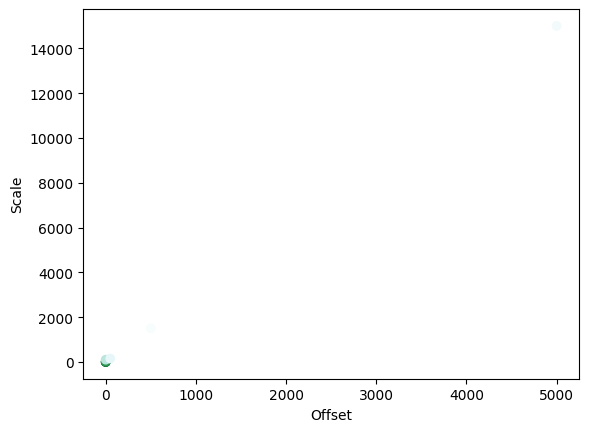

In [63]:
def plot_unif_accuracy(results):
    xs, ys = list(zip(*results.keys()))
    vals = list(results.values())
    plt.scatter(xs, ys, c=vals, cmap='BuGn')
    plt.xlabel('Offset')
    plt.ylabel('Scale')
    plt.show()

unif_dist_results = {
    (0, 0.001): 0.928,
    (1, 0.001): 0.962,
    (0, 0.1): 0.931,
    (0, 10): 0.883,
    (0, 100): 0.77,
    (50, 150): 0.72,
    (500, 1500): 0.69,
    (5000, 15000): 0.7  
}

unif_cross_train = {
    (0, 0.001): 0.948,
    (1, 0.001): 0.967,
    (0, 0.1): 0.916,
    (0, 10): 0.86,
    (0, 100): 0.75,
    (50, 150): 0.72,
    (500, 1500): 0.72,
    (5000, 15000): 0.69  
}

plot_unif_accuracy(unif_dist_results)

ER p=0.25, 100 8x8 train and 40 32x32 test => 0.94 in 100 iterations

BA param=3, 100 8x8 train and 40 32x32 test => 0.97 in 100 iterations

BA param=5, 100 8x8 train and 40 32x32 test => 0.95 in 100 iterations (0.951 in 200 so has pretty much converged after 100)

BA param=7, 100 8x8 train and 40 32x32 test => 0.946 in 100 iterations

#### Cross training
BA param=7 to BA param=3

BA param=7 to ER p=0.25 0.946 with BA to 0.939 with ER (same as if trained only on BA)

ER p=0.25 to BA param=3 went from 0.939 with ER to 0.967 with BA (BA param 3 was 0.97 so basically nothing lost)

#### Weight variations
Uniform
* 0,0.001 -> 0.928
* 1,1.001 -> 0.962
* 0,0.1 -> 0.931
* 0,10 -> 0.883
* 0,100 -> 0.77
* 50, 200 -> 0.72
* 500, 2000 -> 0.69
* 5000, 20000 -> 0.7

Normal:
Basically same.

Gumbel
* 0,0.001 -> 0.323
* 1,1.001 -> 0.849
* 0,0.1 -> 0.498
* 5,10 -> 0.82
* 5,100 -> 0.8

#### Weight cross training
Train ER p=0.25 unif 0,1:
* 0,0.001 -> 0.948
* 1,1.001 -> 0.967
* 0,0.1 -> 0.916
* 0,10 -> 0.86
* 0,100 -> 0.75
* 50, 200 -> 0.72
* 500, 2000 -> 0.72
* 5000, 20000 -> 0.69

=> Seems to weight generalize quite well. Actually even better because basically no statistical difference with if we trained separately.

Train normal 5000, 20000:
* 0, 0.001 -> 0.39 (maybe it's the large to small that was a problem here? Also those values make little sense for a normal RV)

Other direction train normal 0, 0.001 (got to 0.78):
* 5000, 20000 -> 0.76

=> small to large seems better


#### Larger graphs
Same training
ER p=0.25 8x8 train:
* 100x100 test goes to 0.88
* 200x200 goes to 0.63 (only 12 prediction mismatches though)


## Preliminary results
random permutation/matching: 0.18

MPNN:
learned predictions: 0.67

GAT:
learned predictions: 0.72

Got better with double ended predictions

Partial: 0.64 while greedy was doing about 0.92 on the same instance. Main reason seems to be that max weight is around 1.5 => can get at most 2/3 OPT


### Counting the number of matching constraints violated

In [41]:
# For two-way
def count_mismatches_two_way(predictions):
    count = 0
    data = predictions["match"].data
    nb_graphs = data.shape[0]
    for datapoint in range(data.shape[0]):
        for i in range(32):
            owner = data[datapoint][i]
            good = data[datapoint][int(owner)]
            if good != i:
                count += 1
    print(f"average number of edges contradicting matching: {count / nb_graphs}")

In [42]:
# For self-loops
def count_mismatches_self_loop(predictions):
    count = 0
    data = predictions["match"].data
    nb_graphs = data.shape[0]
    for datapoint in range(data.shape[0]):
        owners = set(np.array(data[datapoint][32:64]))
        count += 32 - len(owners)
    print(f"average number of edges contradicting matching: {count / nb_graphs}")


In [14]:
a = np.array([1, 2])
b = np.array([2, 3])
print(np.concatenate((a, b)))

[1 2 2 3]
